In [1]:
#import
import numpy as np 
import random as rd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
rd.seed(420) #:)

### Method 1

In [2]:
def bond_price(T1,T2,r,Th,sigma,k):
    B = 1/k*(1-np.exp(-k*(T2-T1)))
    A = np.exp((Th-sigma**2/(2*k**2))*(B-(T2-T1))-sigma**2/(4*k)*B**2)
    return A*np.exp(-B*r)

def max_z(a):
    res = np.array([])
    for k in range(0,len(a)):
        if a[k] > 0:
            res = np.append(res,a[k])
        else:
            res = np.append(res,0)
    return res

In [3]:
K = 0.805
k = 0.15
sigma_r = 0.01
theta = 0.05
r0 = 0.042
T1 = 0.25
T2 = 5.25

B_T1T2 = 1/k*(1-np.exp(-k*(T2-T1)))
sigma_t = sigma_r*np.sqrt((1-np.exp(-2*k*T1))/(2*k))*B_T1T2
h=1/sigma_t*np.log(bond_price(0,T2,r0,theta,sigma_r,k)/(K*bond_price(0,T1,r0,theta,sigma_r,k)))+sigma_t/2

In [4]:
price_1 = K*bond_price(0,T1,r0,theta,sigma_r,k)*norm.cdf(-h+sigma_t)-bond_price(0,T2,r0,theta,sigma_r,k)*norm.cdf(-h)

In [5]:
price_1

0.0074897997038153585

### Method 2

In [6]:
price_2 = []
r_density = np.arange(100,1000,5)
r_min = 0
r_max = 1
dt = 0.001
t_grid = np.arange(0,T1,dt)
for ri in r_density:
    dr=1/ri
    r_grid = np.arange(r_min,r_max,dr)
    V = np.zeros((len(t_grid),len(r_grid)))
    A = -dt*k*0.5*(theta-r_grid[1:len(r_grid)-2])/dr+sigma_r**2*dt*0.5/dr**2
    B = 1-sigma_r**2*dt/dr**2-dt*r_grid[1:len(r_grid)-2]
    C = A+dt*k*(theta-r_grid[1:len(r_grid)-2])/dr
    
    V[len(t_grid)-1,:] = max_z(K-bond_price(T1, T2, r_grid, theta, sigma_r, k))
    V[:,0] = K-bond_price(T1, T2, 0, k, theta, sigma_r)
    V[:,len(r_grid)-1] = 0
    for t in range(len(t_grid)-2,-1,-1):
        V[t, 1:len(r_grid)-2]=A*V[t+1,0:len(r_grid)-3]+B*V[t+1,1:len(r_grid)-2]+C*V[t+1, 2:len(r_grid)-1]; 
    r_grid_down = r_grid[np.where(r_grid < r0)[0][-1]]
    r_grid_up = r_grid[np.where(r_grid > r0)[0][0]]
    v_down = V[0,np.where(r_grid < r0)[0][-1]]
    v_up = V[0,np.where(r_grid > r0)[0][0]]
    price_2 += [v_down+(v_up-v_down)*(r0-r_grid_down)/(r_grid_up-r_grid_down)]

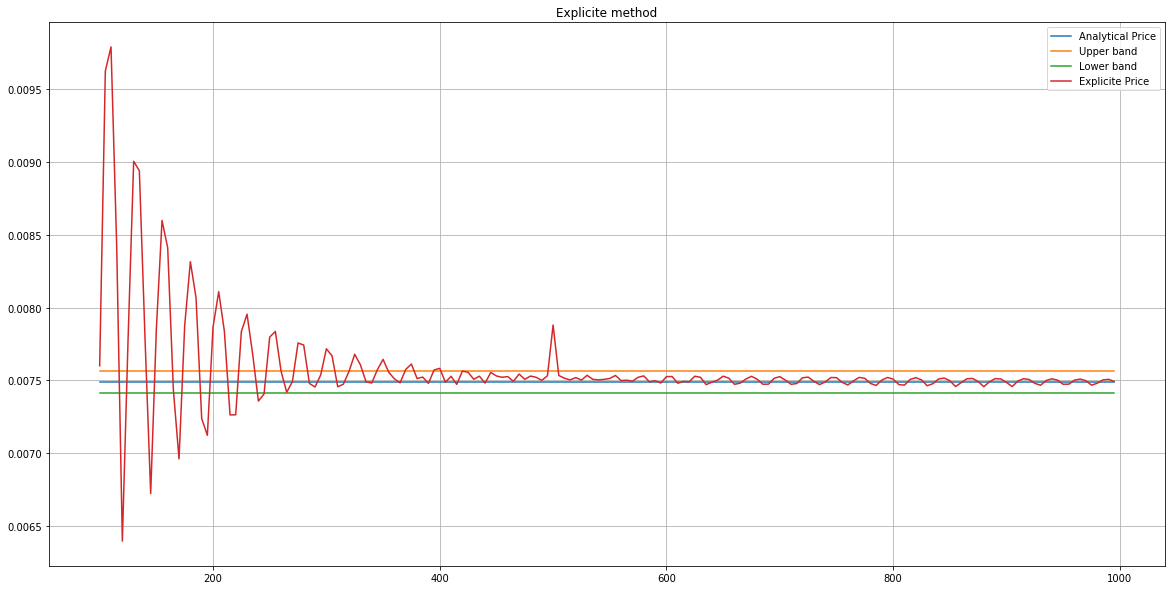

In [7]:
plt.figure(figsize=(20,10))
plt.plot(r_density,len(r_density)*[price_1],label = 'Analytical Price')
plt.plot(r_density,len(r_density)*[1.01*price_1], label = 'Upper band')
plt.plot(r_density,len(r_density)*[0.99*price_1], label = 'Lower band')
plt.plot(r_density,price_2, label = 'Explicite Price')
plt.legend()
plt.title('Explicite method')
plt.grid()
plt.show()

### Method 3

In [8]:
price_3 = []
r_density = np.arange(100,1000,5)
r_min = 0
r_max = 1
dt = 0.001
t_grid = np.arange(0,T1,dt)
for ri in tqdm(r_density):
    dr=1/ri
    r_grid = np.arange(r_min,r_max,dr)
    V = np.zeros((len(t_grid),len(r_grid)))
    A = dt*k*0.25*(theta-r_grid[1:len(r_grid)-2])/dr - sigma_r**2*dt*0.25/dr**2
    B = 1 + 0.5*sigma_r**2*dt/dr**2 + 0.5*dt*r_grid[1:len(r_grid)-2]
    C = -dt*k*0.25*(theta - r_grid[1:len(r_grid)-2])/dr - sigma_r**2*dt*0.25/dr**2
    
    #creating matrix
    l = len(B)
    aM = np.diag(A[1:],k= -1)
    bM = np.diag(B)
    cM = np.diag(C[:-1],k= 1)
    M = aM+bM+cM

    A_ = -A
    B_ = 1 - 0.5*sigma_r**2*dt/dr**2 - 0.5*dt*r_grid[1:len(r_grid)-2]
    C_ = -C
    
    aM_ = np.diag(A_[1:],k= -1)
    bM_ = np.diag(B_)
    cM_ = np.diag(C_[:-1],k= 1)
    M_ = aM_+bM_+cM_
    
    V[len(t_grid)-1,:] = max_z(K-bond_price(T1, T2, r_grid, theta, sigma_r, k))
    V[:,0] = K-bond_price(T1, T2, 0, k, theta, sigma_r)
    V[:,len(r_grid)-1] = 0
    
    Minv = np.linalg.inv(M)
    for t in range(len(t_grid)-2,-1,-1):
        b = np.zeros(l)
        b[1] = A[0]*V[t+1,0]
        b[len(b)-1] = C[len(C)-1]*V[t+1,len(r_grid)-1]
        V[t, 1:len(r_grid)-2] = np.dot(Minv,np.dot(M_,V[t+1,1:len(r_grid)-2])- b) 
    
    r_grid_down = r_grid[np.where(r_grid < r0)[0][-1]]
    r_grid_up = r_grid[np.where(r_grid > r0)[0][0]]
    v_down = V[0,np.where(r_grid < r0)[0][-1]]
    v_up = V[0,np.where(r_grid > r0)[0][0]]
    price_3 += [v_down+(v_up-v_down)*(r0-r_grid_down)/(r_grid_up-r_grid_down)]

100%|██████████| 180/180 [00:13<00:00,  5.95it/s]


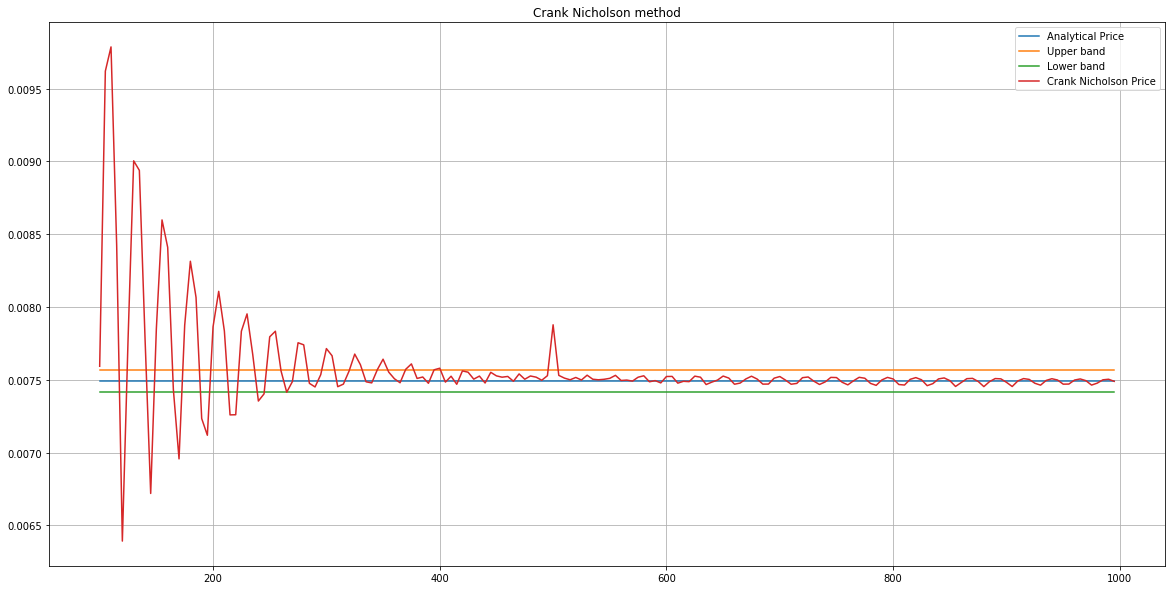

In [9]:
plt.figure(figsize=(20,10))
plt.plot(r_density,len(r_density)*[price_1],label = 'Analytical Price')
plt.plot(r_density,len(r_density)*[1.01*price_1], label = 'Upper band')
plt.plot(r_density,len(r_density)*[0.99*price_1], label = 'Lower band')
plt.plot(r_density,price_3, label = 'Crank Nicholson Price')
plt.legend()
plt.title('Crank Nicholson method')
plt.grid()
plt.show()

### Method 4 (implicite)

In [10]:
price_4 = []
r_density = np.arange(100,1000,5)
r_min = 0
r_max = 1
dt = 0.001
t_grid = np.arange(0,T1,dt)
for ri in tqdm(r_density):
    dr=1/ri
    r_grid = np.arange(r_min,r_max,dr)
    V = np.zeros((len(t_grid),len(r_grid)))
    A = dt*k*0.5*(theta-r_grid[1:len(r_grid)-2])/dr - sigma_r**2*dt*0.5/dr**2
    B = 1 + sigma_r**2*dt/dr**2 + dt*r_grid[1:len(r_grid)-2]
    C = -dt*k*0.5*(theta - r_grid[1:len(r_grid)-2])/dr - sigma_r**2*dt*0.5/dr**2
    
    #creating matrix
    l = len(B)
    aM = np.diag(A[1:],k= -1)
    bM = np.diag(B)
    cM = np.diag(C[:-1],k= 1)
    M = aM+bM+cM

    V[len(t_grid)-1,:] = max_z(K-bond_price(T1, T2, r_grid, theta, sigma_r, k))
    V[:,0] = K-bond_price(T1, T2, 0, k, theta, sigma_r)
    V[:,len(r_grid)-1] = 0
    
    Minv = np.linalg.inv(M)
    for t in range(len(t_grid)-2,-1,-1):
        b = np.zeros(l)
        b[1] = A[0]*V[t+1,0]
        b[len(b)-1] = C[len(C)-1]*V[t+1,len(r_grid)-1]
        V[t, 1:len(r_grid)-2] = np.dot(Minv,V[t+1,1:len(r_grid)-2]- b) 
    
    r_grid_down = r_grid[np.where(r_grid < r0)[0][-1]]
    r_grid_up = r_grid[np.where(r_grid > r0)[0][0]]
    v_down = V[0,np.where(r_grid < r0)[0][-1]]
    v_up = V[0,np.where(r_grid > r0)[0][0]]
    price_4 += [v_down+(v_up-v_down)*(r0-r_grid_down)/(r_grid_up-r_grid_down)]

100%|██████████| 180/180 [00:08<00:00,  8.50it/s]


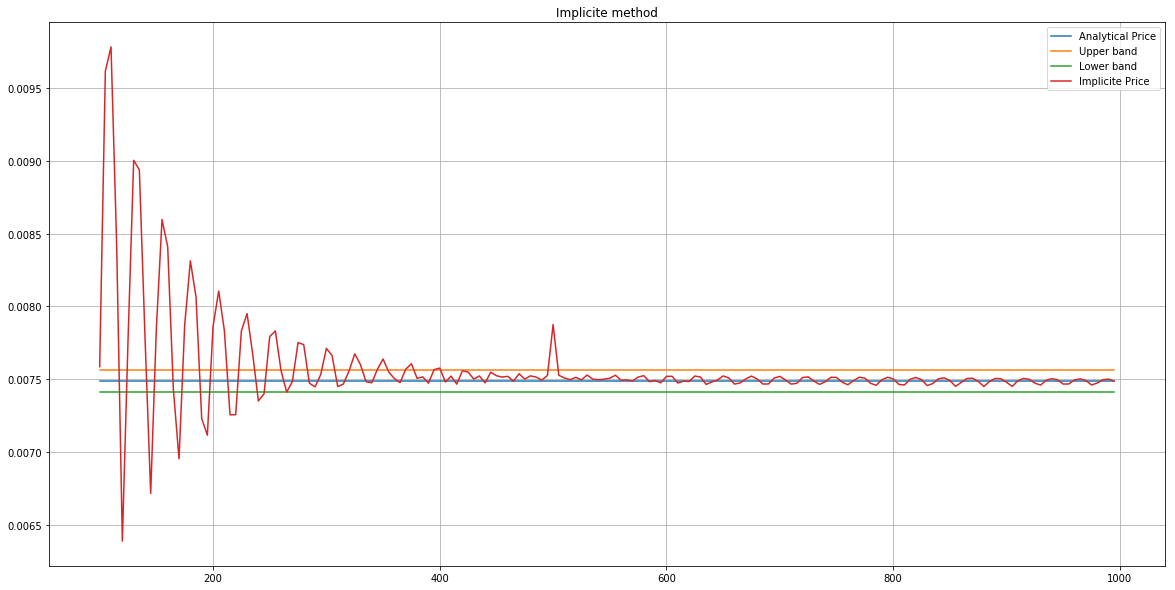

In [11]:
plt.figure(figsize=(20,10))
plt.plot(r_density,len(r_density)*[price_1],label = 'Analytical Price')
plt.plot(r_density,len(r_density)*[1.01*price_1], label = 'Upper band')
plt.plot(r_density,len(r_density)*[0.99*price_1], label = 'Lower band')
plt.plot(r_density,price_4, label = 'Implicite Price')
plt.legend()
plt.title('Implicite method')
plt.grid()
plt.show()

### Method 5 (implicit + explicite)/2

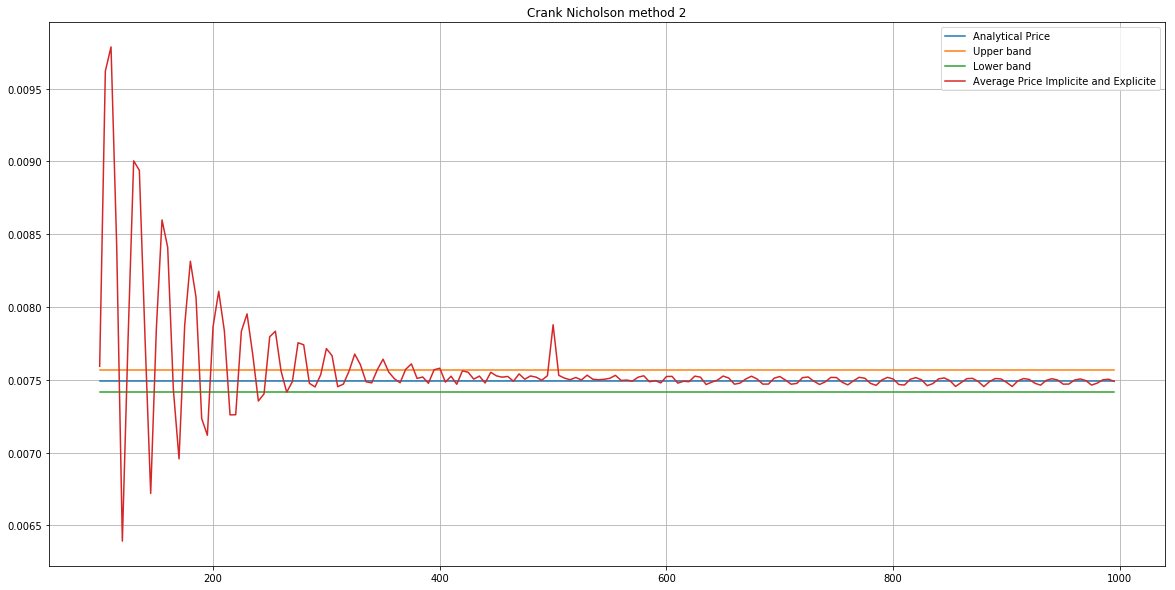

In [12]:
plt.figure(figsize=(20,10))
plt.plot(r_density,len(r_density)*[price_1],label = 'Analytical Price')
plt.plot(r_density,len(r_density)*[1.01*price_1], label = 'Upper band')
plt.plot(r_density,len(r_density)*[0.99*price_1], label = 'Lower band')
plt.plot(r_density,(np.array(price_4)+np.array(price_2))/2, label = 'Average Price Implicite and Explicite')
plt.legend()
plt.title('Crank Nicholson method 2')
plt.grid()
plt.show()

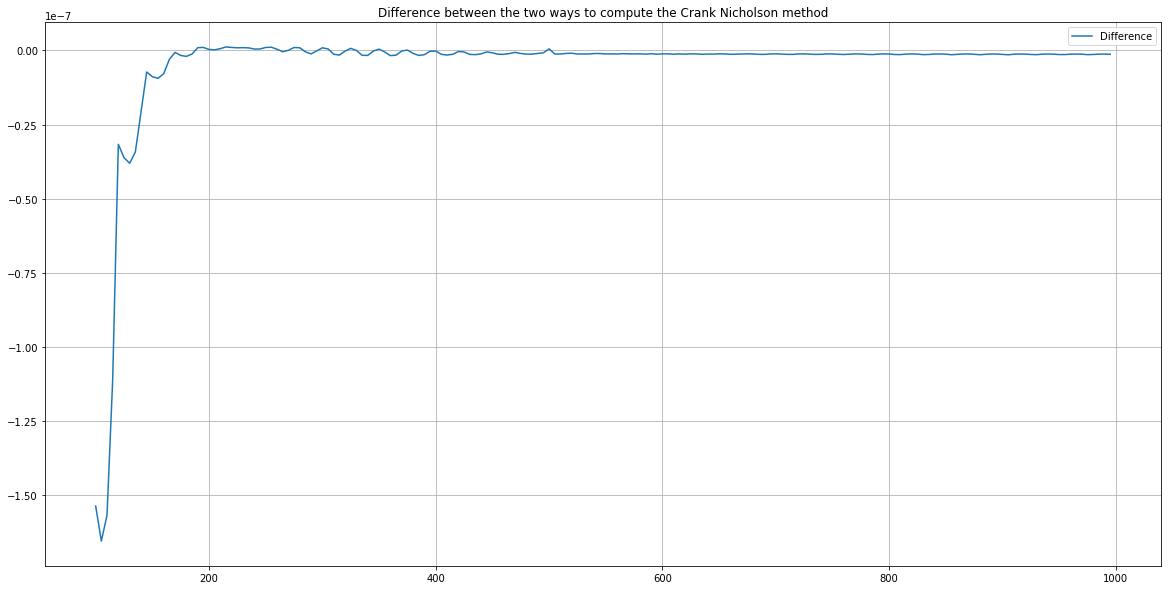

In [13]:
plt.figure(figsize=(20,10))
plt.plot(r_density,(np.array(price_4)+np.array(price_2))/2 - np.array(price_3), label = 'Difference')
plt.legend()
plt.title('Difference between the two ways to compute the Crank Nicholson method')
plt.grid()
plt.show()

### Conclusion 

We choose dt to be constant and we choose to variate dr, in the light of the previous graph we show that after 400 our price is in the confidence interval but we have a small pick out, so we conclued that after 500 our price is in the confidence interval. So we should choose dr = 1/500 = 0.002. We saw that when we change dt we shift the graph down or up. Also we compute the Crank Nicholson method using 2 ways.